<a href="https://colab.research.google.com/github/daycardoso/PredictCost/blob/main/PredicCostRandomForestRegressor.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Dimensões de X: (6336328, 8)

Dimensões de y: (6336328,)

Nomes dos atributos: Index(['x0', 'y0', 'theta0', 'beta0', 'xf', 'yf', 'thetaf', 'betaf'], dtype='object')

Nomes das classes: cost


Add `%load_ext cuml.accel` before importing sklearn to speed up operations using GPU


In [ ]:
import pandas as pd
# Carregar o datset unificado
df_unificado = pd.read_csv('/content/drive/MyDrive/Trabalho ML Mestrado 01-2025/df_unificado.csv')

# matriz contendo os atributos
X = df_unificado.iloc[:, :-1]

# vetor contendo o custo, ou seja, a ultima coluna
y = df_unificado.iloc[:, -1]

# nome de cada atributo
feature_names = df_unificado.columns[:-1]

# nome de cada classe
target_names = df_unificado.columns[-1]

print(f"Dimensões de X: {X.shape}\n")
print(f"Dimensões de y: {y.shape}\n")
print(f"Nomes dos atributos: {feature_names}\n")
print(f"Nomes das classes: {target_names}")


import cuml
import cudf
import cupy as cp
import joblib
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from cuml.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_validate, RepeatedKFold
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    r2_score, mean_squared_error, mean_absolute_error,
    mean_absolute_percentage_error, median_absolute_error,
    max_error, explained_variance_score
)
from IPython.display import display

# Convertendo os dados para cudf (GPU)
X_cudf = cudf.DataFrame.from_pandas(X)
y_cudf = cudf.Series(y)

# Hold-out
X_train_full, X_test, y_train_full, y_test = train_test_split(
    X_cudf, y_cudf, test_size=0.3, random_state=42
)

# Treinamento
modelo = RandomForestRegressor(
    random_state=42,
    max_depth=20,
    n_estimators=100,
    # n_streams=-1
)
modelo.fit(X_train_full, y_train_full)

# Predição no hold-out (converte para numpy)
y_pred_gpu = modelo.predict(X_test)
# Change .to_array() to .to_numpy() to convert cudf.Series to numpy array
y_pred = y_pred_gpu.to_numpy()
# Change .to_array() to .to_numpy() to convert cudf.Series to numpy array
y_test_cpu = y_test.to_numpy()

# 5×5 CV repetida: balanceia viés x variância na estimação
cv = RepeatedKFold(n_splits=5, n_repeats=5, random_state=42)

scoring = {
    'R2': 'r2',
    'MSE': 'neg_mean_squared_error',
    'MAE': 'neg_mean_absolute_error',
    # 'MAPE': 'neg_mean_absolute_percentage_error',
    'MedAE': 'neg_median_absolute_error',
    'MaxE': 'max_error',
    'EVS': 'explained_variance',
}

cv_results = cross_validate(
    modelo, X_train_full, y_train_full,
    cv=cv, scoring=scoring, return_train_score=True#, n_jobs=-1
)

cv_results_df = pd.DataFrame(cv_results)

# Salvamento (conversão para compatibilidade com joblib)
full_results = {
    'pipeline': modelo,
    'X_test':   X_test.to_pandas(),
    'y_test':   y_test_cpu,
    'y_pred':   y_pred,
    'cv_results': cv_results_df,
    'feature_names': X.columns.tolist()
}
joblib.dump(full_results, '/content/drive/MyDrive/Trabalho ML Mestrado 01-2025/randon_forest_regressor_full_results.pkl')

# Carregar resultados
res = joblib.load('/content/drive/MyDrive/Trabalho ML Mestrado 01-2025/randon_forest_regressor_full_results.pkl')
model         = res['pipeline']
X_test        = res['X_test']
y_true        = res['y_test']
# Change .to_array() to .to_numpy() to convert cudf.Series to numpy array
y_pred        = res.get('y_pred', model.predict(cudf.DataFrame.from_pandas(X_test)).to_numpy())
feature_names = res.get('feature_names', getattr(X_test, 'columns', None))

# 1) Exibir métricas
metrics = {
    'R² Score'          : r2_score(y_true, y_pred),
    'MSE'               : mean_squared_error(y_true, y_pred),
    'MAE'               : mean_absolute_error(y_true, y_pred),
    'MAPE'              : mean_absolute_percentage_error(y_true, y_pred),
    'Median AE'         : median_absolute_error(y_true, y_pred),
    'Max Error'         : max_error(y_true, y_pred),
    'Explained Variance': explained_variance_score(y_true, y_pred)
}
df_metrics = pd.DataFrame.from_dict(metrics, orient='index', columns=['Valor']).round(4)
display(df_metrics)

# 2) Gráfico real vs predito
plt.figure()
plt.scatter(y_true, y_pred, alpha=0.5)
min_val, max_val = np.min([y_true.min(), y_pred.min()]), np.max([y_true.max(), y_pred.max()])
plt.plot([min_val, max_val], [min_val, max_val], 'r--')
plt.xlabel('Valor Real')
plt.ylabel('Valor Predito')
plt.title('Real vs Predito')
plt.grid(True)
plt.tight_layout()
plt.show()

# 3) Histograma de resíduos
residuals = y_true - y_pred
plt.figure()
plt.hist(residuals, bins=50)
plt.xlabel('Resíduo (Real - Predito)')
plt.title('Histograma de Resíduos')
plt.grid(True)
plt.tight_layout()
plt.show()

# 4) Boxplot de resíduos por quartil
df_r = pd.DataFrame({'Real': y_true, 'Resíduo': residuals})
df_r['Quartil'] = pd.qcut(df_r['Real'], 4, labels=[1, 2, 3, 4])
groups = [df_r[df_r['Quartil'] == q]['Resíduo'] for q in sorted(df_r['Quartil'].unique())]
plt.figure()
plt.boxplot(groups, labels=sorted(df_r['Quartil'].unique()))
plt.xlabel('Quartil de Valor Real')
plt.ylabel('Resíduo')
plt.title('Boxplot de Resíduos por Quartil')
plt.grid(True)
plt.tight_layout()
plt.show()

# 5) Importância das features (compatível com cuML)
if hasattr(model, 'feature_importances_') and feature_names is not None:
    # Change .to_array() to .to_numpy() to convert cudf.Series to numpy array
    fi = pd.Series(model.feature_importances_.to_numpy(), index=feature_names).sort_values(ascending=False)
    plt.figure(figsize=(10, 4))
    fi.plot(kind='bar')
    plt.ylabel('Importância')
    plt.title('Importância das Features')
    plt.tight_layout()
    plt.show()

A saída de streaming foi truncada nas últimas 5000 linhas.

  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_validation.py:978: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_scorer.py", line 140, in __call__
    score = scorer._score(
            ^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_scorer.py", line 388, in _score
    return self._sign * self._score_func(y_true, y_pred, **scoring_kwargs)
                        ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/sklearn/utils/_param_validation.py", line 216, in wrapper
    return func(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_regression.py", line 1257, in r2_score
    _chec

['/content/drive/MyDrive/Trabalho ML Mestrado 01-2025/randon_forest_regressor_full_results.pkl']

,Valor
R² Score,6.230000e-01
MSE,1.400000e-03
MAE,3.110000e-02
MAPE,8.570861e+08
Median AE,2.650000e-02
Max Error,2.400000e-01
Explained Variance,7.284000e-01


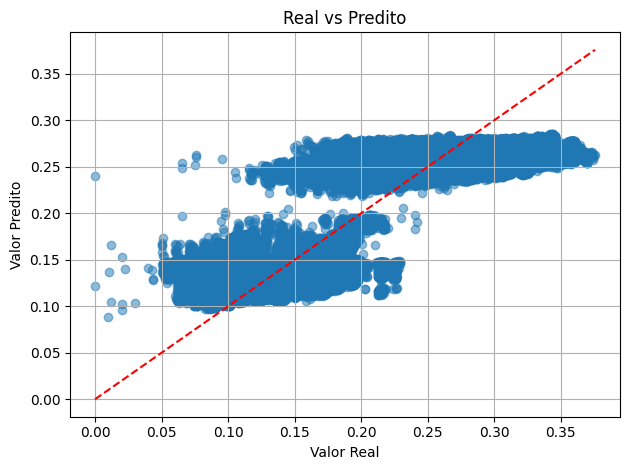

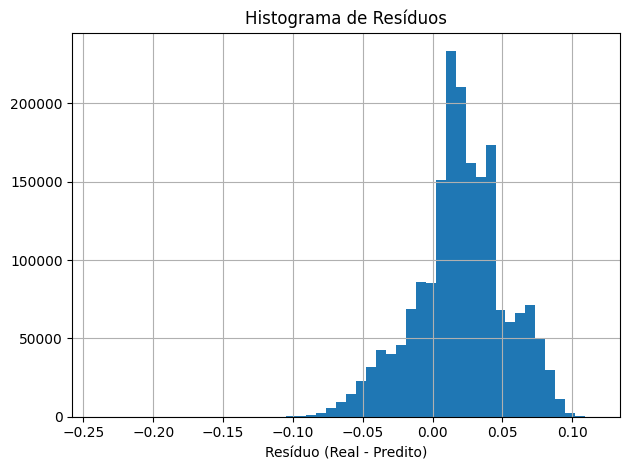

<ipython-input-4-52533c48f2d5>:50: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(groups, labels=sorted(df_r['Quartil'].unique()))


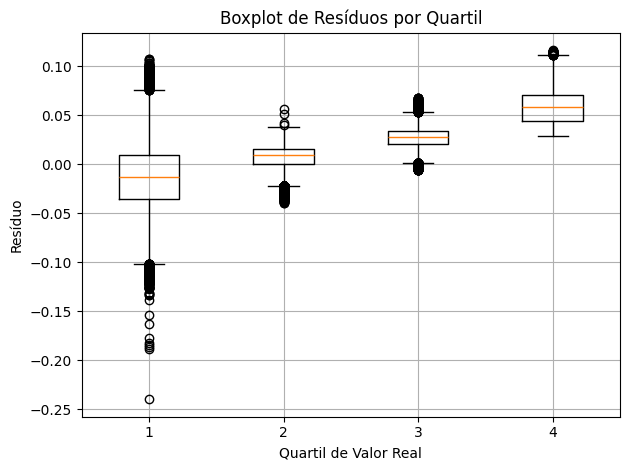